In [213]:
# import what we need
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import logging
# logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

# pandas settings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [388]:
# columns required
relevant_cols = [
    "full_name",
    "round",
    "season",
    "minutes",
    "goals_conceded",
    "saves",
    "influence",
#     "expected_goals_conceded", only gathered from 2223 onwards, not enough data yet for testing
    "gw_total_points"
]

features = [
    "cumulative_season_goals_conceded", 
     "cumulative_season_saves", 
     "cumulative_season_influence"
]

plotting_colours = [
    "orangered",
    "gold",
    "forestgreen",
    "deepskyblue",
    "mediumorchid"
]

In [3]:
# get the whole dataset and take only the goalkeepers
dataset = pd.read_csv("data/training_datasets/raw_gw_data.csv")
goalkeepers = dataset.loc[dataset["position"] == "GKP", :]

In [4]:
# so many columns we don't need
goalkeepers_lite = goalkeepers[relevant_cols].reset_index(drop=True)
goalkeepers_lite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13124 entries, 0 to 13123
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   full_name        13124 non-null  object 
 1   round            13124 non-null  int64  
 2   season           13124 non-null  int64  
 3   minutes          13124 non-null  int64  
 4   goals_conceded   13124 non-null  int64  
 5   saves            13124 non-null  int64  
 6   influence        13124 non-null  float64
 7   gw_total_points  13124 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 820.4+ KB


## Use a linear regression to understand goalkeeper performance

### 1. cumulative summary and filtering

In [5]:
# create a cumsum of all features
goalkeepers_lite["cumulative_season_minutes"] = goalkeepers_lite.groupby(["full_name", "season"])["minutes"].cumsum()
goalkeepers_lite["cumulative_season_goals_conceded"] = goalkeepers_lite.groupby(["full_name", "season"])["goals_conceded"].cumsum()
goalkeepers_lite["cumulative_season_saves"] = goalkeepers_lite.groupby(["full_name", "season"])["saves"].cumsum()
goalkeepers_lite["cumulative_season_influence"] = goalkeepers_lite.groupby(["full_name", "season"])["influence"].cumsum()
goalkeepers_lite["cumulative_season_points"] = goalkeepers_lite.groupby(["full_name", "season"])["gw_total_points"].cumsum()

# remove keepers where they didn't play enough games - gone with 900 mins across each season
goalkeepers_lite = goalkeepers_lite.groupby(["full_name", "season"]).filter(lambda g: g.cumulative_season_minutes.max() > 900)

### 2. Prep data for modelling - will use 2223 season as test

In [6]:
# split into test and train
train = goalkeepers_lite.loc[goalkeepers_lite["season"] != 2223, :]
test = goalkeepers_lite.loc[goalkeepers_lite["season"] == 2223, :]

# train
X_train = train[["cumulative_season_goals_conceded", 
                 "cumulative_season_saves", 
                 "cumulative_season_influence"]]
y_train = train["cumulative_season_points"]

# test
X_test = test[["cumulative_season_goals_conceded", 
               "cumulative_season_saves", 
               "cumulative_season_influence"]]
y_test = test["cumulative_season_points"]

In [8]:
# instantiate and fit
reg = LinearRegression()
reg = reg.fit(X_train, y_train)

# predict test and train X
train_preds = reg.predict(X_train).tolist()
test_preds = reg.predict(X_test).tolist()
r2 = r2_score(y_test, test_preds)

# get test r2 and mae scores
print(r2)
mae = mean_absolute_error(y_test, test_preds)
print(mae)

0.8605412483858881
11.68345293711869


In [9]:
print(f"\033[1m projected points = \n\tgoals_conceded({reg.coef_[0]}) + \n\tsaves({reg.coef_[1]}) + \n\tinfluence({reg.coef_[2]}) + \n\t{reg.intercept_}")

 projected points = 
	goals_conceded(-1.3563395405864958) + 
	saves(-1.0310387213834997) + 
	influence(0.35645553027291343) + 
	5.277528571688855


## Plotting

In [11]:
# get jordan pickford's 2223 scores
jp_2223 = goalkeepers_lite.loc[(goalkeepers_lite["full_name"] == "nick_pope") & 
                              (goalkeepers_lite["season"] == 2223), 
                               ["cumulative_season_goals_conceded", 
                                "cumulative_season_saves", 
                                "cumulative_season_influence",
                                "cumulative_season_points"]]

# jp_2223_rounds = goalkeepers_lite.loc[(goalkeepers_lite["full_name"] == "david_raya martin") & 
#                                       (goalkeepers_lite["season"] == 2223), "round"].values

In [12]:
jp_actuals = jp_2223["cumulative_season_points"].tolist()
jp_preds = reg.predict(jp_2223.iloc[:, 0:3]).tolist()

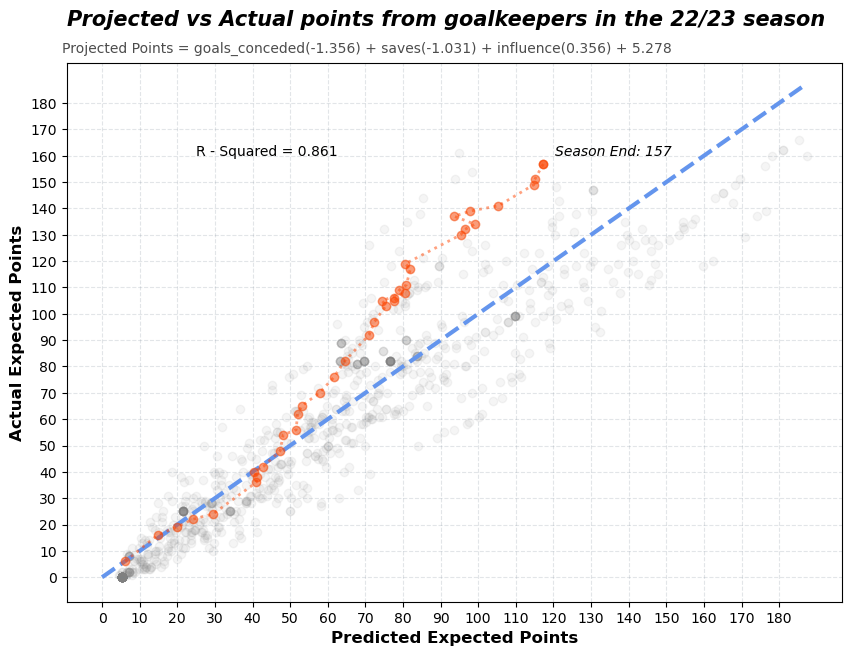

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

# plottting
p1 = int(max(max(y_test), max(test_preds)))
plt.scatter(test_preds, y_test, color="grey", alpha=0.08)
plt.plot(range(p1), range(p1), color="cornflowerblue", linewidth=3, linestyle="--", alpha=1)
plt.plot(jp_preds, jp_actuals, ':o', color="orangered", linewidth=2, alpha=0.5)
plt.annotate(f"Season End: {int(jp_actuals[-1])}", (jp_preds[-1]+3, jp_actuals[-1]+3), fontsize=10, fontstyle="italic")
# for i in range(len(jp_preds)):
#     plt.annotate(jp_2223_rounds[i], (jp_preds[i]-2, jp_actuals[i]-2), fontsize=8)

# plot details
plt.grid(alpha=0.2, color="slategray", linestyle="--")
plt.xticks(range(0, p1, 10))
plt.yticks(range(0, p1, 10))

# titles and annotation
plt.title(
    "Projected vs Actual points from goalkeepers in the 22/23 season\n",
    fontsize=15,
    fontweight="bold",
    fontstyle="italic",
    pad=10,
    loc="left",
)
plt.suptitle(
    f"Projected Points = goals_conceded({round(reg.coef_[0], 3)}) + saves({round(reg.coef_[1], 3)}) + influence({round(reg.coef_[2], 3)}) + {round(reg.intercept_, 3)}",
    fontsize=10,
    alpha=0.7,
    x=0.12,
    y=0.91,
    ha="left",
)
plt.annotate(f"R - Squared = {round(r2, 3)}", (25, 160))
plt.xlabel('Predicted Expected Points', fontsize=12, fontweight="bold")
plt.ylabel('Actual Expected Points', fontsize=12, fontweight="bold")

plt.show()

## Create a class which can do everything for us

We want a class that can: 
1. take the raw dataframe 
2. calculate the regression 
3. plot the graph without a player 
4. plot a graph with any player/players given

In [426]:
class GoalkeeperAnalyser:
    """taking the whole database, will perform a regression of goalkeeper expected points and return a plot
    of every player as well as a user defined player/players"""
    
    def __init__(self, database):
        """class is initiated with the whole database"""
        self.database = database
        self.goalkeeper_df_lite = None
        self.latest_season = None
        self.y_train = None
        self.y_test = None
        self.train_preds = None
        self.test_preds = None
        self.r2 = None
        self.coefs = {}
        
        self.preprocess(database)
        
    def preprocess(self, database):
        """does basic preprocessing of raw database to prepare for modelling"""
        
        if not all(col in database.columns for col in relevant_cols):
            logger.error(" Dataframe does not have required columns")
            return None
        
        # get the cols we need
        goalkeeper_df = database.loc[dataset["position"] == "GKP", :]
        goalkeeper_df_lite = goalkeeper_df[relevant_cols].reset_index(drop=True)
        
        # create cumsum of relevant cols
        goalkeeper_df_lite["cumulative_season_minutes"] = goalkeeper_df_lite.groupby(["full_name", "season"])["minutes"].cumsum()
        goalkeeper_df_lite["cumulative_season_goals_conceded"] = goalkeeper_df_lite.groupby(["full_name", "season"])["goals_conceded"].cumsum()
        goalkeeper_df_lite["cumulative_season_saves"] = goalkeeper_df_lite.groupby(["full_name", "season"])["saves"].cumsum()
        goalkeeper_df_lite["cumulative_season_influence"] = goalkeeper_df_lite.groupby(["full_name", "season"])["influence"].cumsum()
        goalkeeper_df_lite["cumulative_season_points"] = goalkeeper_df_lite.groupby(["full_name", "season"])["gw_total_points"].cumsum()
        
        # remove keepers where they didn't play enough games - gone with 900 mins across each season
        goalkeeper_df_lite = goalkeeper_df_lite.groupby(["full_name", "season"]).filter(lambda g: g.cumulative_season_minutes.max() > 900)
        
        self.goalkeeper_df_lite = goalkeeper_df_lite
        self.latest_season = goalkeeper_df_lite["season"].max()
        
    def do_regression(self):
        """performs a regression using the relevant features to predict projected points"""
        
        # split into test and train, using the latest year as test
        train = self.goalkeeper_df_lite.loc[self.goalkeeper_df_lite["season"] != self.latest_season, :]
        test = self.goalkeeper_df_lite.loc[self.goalkeeper_df_lite["season"] == self.latest_season, :]
        
        # get our feature and target cols
        X_train = train[features]
        y_train = train["cumulative_season_points"]
        X_test = test[features]
        y_test = test["cumulative_season_points"]
        
        # instantiate and fit
        reg = LinearRegression()
        reg = reg.fit(X_train, y_train)

        # predict test and train X
        train_preds = reg.predict(X_train).tolist()
        test_preds = reg.predict(X_test).tolist()
        r2 = r2_score(y_test, test_preds)
        
        # create coef dict
        coefs = {features[i]: reg.coef_[i] for i in range(len(features))}
        coefs["intercept"] = reg.intercept_

        # assign vars to class
        self.y_train = y_train
        self.y_test = y_test
        self.model = reg
        self.train_preds = train_preds
        self.test_preds = test_preds
        self.r2 = r2
        self.coefs = coefs
        
    def make_plot(self, players=[], show=True):
        """plots the regression results with any specified players highlighted"""
        
        # regression must be done first
        if self.y_train is None:
            logger.error(" Regression must be performed prior to plotting")
            return None

        # plottting
        fig, ax = plt.subplots(figsize=(10, 7))
        p1 = int(max(max(self.y_test), max(self.test_preds)))
        ax.scatter(self.test_preds, self.y_test, color="grey", alpha=0.08)
        ax.plot(range(p1), range(p1), color="cornflowerblue", linewidth=3, linestyle="--", alpha=1)
        
        # adding players
        if players != []:
            players = players if isinstance(players, list) else [players]
            for i in range(len(players)):
                if i > 4:
                    logger.error(f" Max number of players is 5, you provided {len(players)}. Skipping remainder")
                    break
                try:
                    player_season = goalkeepers_lite.loc[(goalkeepers_lite["full_name"] == players[i]) & 
                          (goalkeepers_lite["season"] == 2223), 
                           ["cumulative_season_goals_conceded", 
                            "cumulative_season_saves", 
                            "cumulative_season_influence",
                            "cumulative_season_points"]]
                    
                    # predict
                    player_actuals = player_season["cumulative_season_points"].tolist()
                    player_preds = self.model.predict(player_season.iloc[:, 0:3]).tolist()
                    
                    # plot
                    ax.plot(player_preds, player_actuals, ':o', color=plotting_colours[i], linewidth=2, alpha=0.5)
                    ax.annotate(f"{players[i]} season end: {int(player_actuals[-1])}", (player_preds[-1]+3, player_actuals[-1]+3), fontsize=8, fontstyle="italic")
                except Exception as e:
                    logging.error(f" Player {players[i]} not in database, maybe a spelling mistake?")
                    continue

        # plot details
        ax.grid(alpha=0.2, color="slategray", linestyle="--")
        ax.set_xticks(range(0, p1, 10))
        ax.set_yticks(range(0, p1, 10))

        # titles and annotation
        ax.set_title(
            f"Projected vs Actual points from goalkeepers in the {self.latest_season} season",
            fontsize=15,
            fontweight="bold",
            fontstyle="italic",
            pad=10,
            loc="left",
        )
        ax.annotate(
            f"""Projected Points = goals_conceded({round(self.coefs["cumulative_season_goals_conceded"], 3)}) + 
            saves({round(self.coefs["cumulative_season_saves"], 3)}) + 
            influence({round(self.coefs["cumulative_season_influence"], 3)}) + 
            {round(self.coefs["intercept"], 3)}""",
            (-4, 155),
            fontsize=10,
            fontweight="bold",
            alpha=0.7,
            ha="left",
        )
        ax.annotate(f"R - Squared = {round(r2, 3)}", (-4, 145), alpha=0.7, fontweight="bold")
        ax.set_xlabel('Predicted Expected Points', fontsize=12, fontweight="bold")
        ax.set_ylabel('Actual Expected Points', fontsize=12, fontweight="bold")
        
        self.figure = fig
        
        if show:
            plt.show()
        
        plt.close()
            
    def save_plot(self, file_name=None, save_path=None):
        """will save the plot to a specified path, if not specified saved to the current directory"""
        
        if file_name is None:
            raise TypeError("Unable to save: required argument 'file_name' is not defined")
            return None
        
        if save_path is None:
            self.figure.savefig(os.path.join(os.getcwd(), file_name))
            logger.info(f" Figure saved to {os.path.join(os.getcwd(), file_name)}!")
        else:
            if os.path.isdir(save_path):
                self.figure.savefig(os.path.join(save_path, file_name))
                logger.info(f" Figure saved to {os.path.join(save_path, file_name)}!")
            else:
                try:
                    os.makedirs(save_path)
                    self.figure.savefig(os.path.join(save_path, file_name))
                    logger.info(f" Figure saved to {os.path.join(save_path, file_name)}!")
                except Exception as e:
                    logger.error(f"Could not create directory: {e}")
                    return None

In [427]:
gkp_a = GoalkeeperAnalyser(dataset)

In [428]:
gkp_a.do_regression()

ERROR:__main__: Max number of players is 5, you provided 6. Skipping remainder


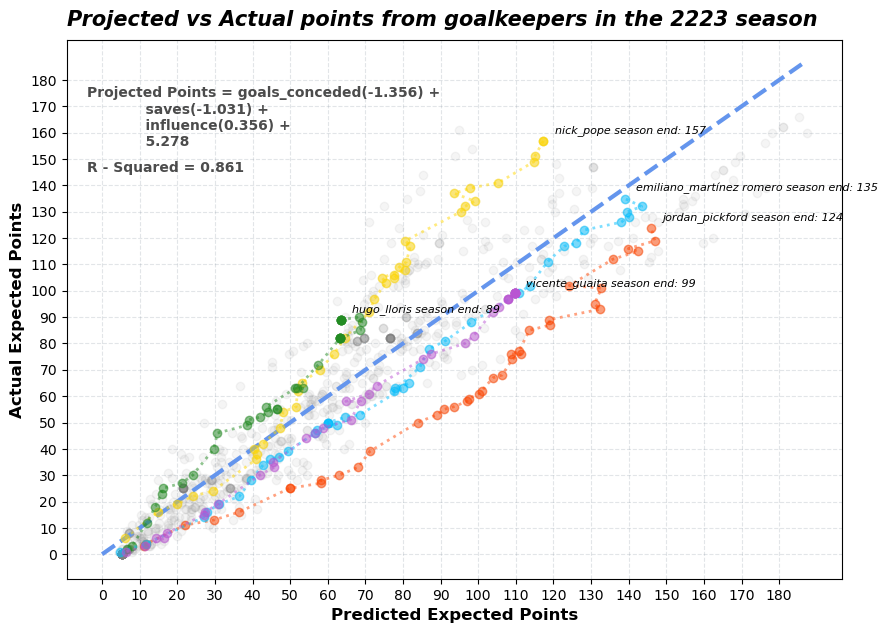

In [429]:
gkp_a.make_plot(players=["jordan_pickford", "nick_pope", "hugo_lloris", "emiliano_martínez romero", "vicente_guaita", "hello"], show=True)

In [431]:
gkp_a.save_plot(file_name="2223_keepers", save_path="plots")

INFO:__main__: Figure saved to plots/2223_keepers!
